# Problem Set 8
## Daniel Tracht

## Question 1

In this question, we want to use the data file from `Biden.csv` to investigate how different factors affect attitudes towards Joe Biden.  We can begin by importing the data:

In [17]:
import pandas as pd

biden = pd.read_csv('Biden.csv', sep=',')

### Part a
After spliting the data into a training set and test set with `random_state=25`, we want to use recursive binary splitting to fit a decision tree to the training data, with `biden` as the response variable and the others as the predictors with the options as described in the problem.


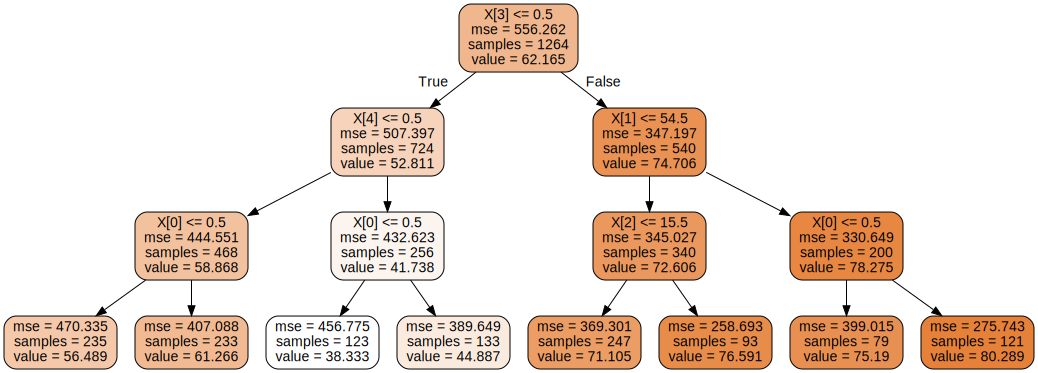

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

# Define the needed variables for this analysis
X = biden[["female", "age", "educ", "dem", "rep"]].values
y = biden["biden"].values

# Divide the data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,
                                                    random_state = 25)
biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree.fit(X_train, y_train)

biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

From the first node, we have whether someone is a Democrat or not as being the first split.  On the left branch, labeled "true", we have those who have less than 0.5 for the dummy for being a Democrat and so are not Democrats.  For those who are not Democrats, the next test is if they are a Republican or not, though both responses lead to branches that use whether or not the respondent is female.

On the right branch, we have those who are Democrats.  The next test is the age of respondent, with the cutoff of 54.5 years.  Those who are less than that age and divided by their years of education, with the cutoff of 15.5 years.  Those who are older than 54.5 years are divided by whether or not they are female.

Looking towards the test data:

In [19]:
from sklearn.metrics import mean_squared_error

y_pred = biden_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print("Test MSE=", MSE1)

Test MSE= 396.1937146321307


### Part b
In this part we want to tune the hyperparameters in the previous method using cross validation, and report the best set of hyperparameters and the average MSE.

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# setting the parameter distributions over which we test as instructed
param_dist1 = {'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20)}

biden_tree2 = DecisionTreeRegressor()

random_search = \
    RandomizedSearchCV(biden_tree2, param_distributions=param_dist1,
                       n_iter=100, n_jobs=-1, cv=5, random_state=25,
                       scoring='neg_mean_squared_error')

random_search.fit(X, y)
print("Best hyperparameters: ", random_search.best_params_)
print("MSE from best hyperparameters: ", -random_search.best_score_)

Best hyperparameters:  {'max_depth': 3, 'min_samples_leaf': 17, 'min_samples_split': 14}
MSE from best hyperparameters:  401.6903602232667


### Part c
In this part, we want to tune the parameters of a Random Forest regression model on the same set of data, and report the best set of hyperparameters and the average MSE.

In [24]:
from sklearn.ensemble import RandomForestRegressor

# setting the parameter distributions over which we test as instructed
param_dist2 = {'n_estimators': [10,200],
              'max_depth': [3,10],
              'min_samples_split': sp_randint(2, 20),
              'min_samples_leaf': sp_randint(2, 20),
              'max_features': sp_randint(1, 5)}

biden_tree3 = RandomForestRegressor()

random_search2 = RandomizedSearchCV(biden_tree3,
                                    param_distributions=param_dist2,
                                    n_iter=100,
                                    n_jobs=-1,
                                    cv=5,
                                    random_state=25,
                                   scoring='neg_mean_squared_error')

random_search2.fit(X, y)
print("Best hyperparameters: ", random_search2.best_params_)
print("MSE from best hyperparameters: ", -random_search2.best_score_)

Best hyperparameters:  {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 200}
MSE from best hyperparameters:  396.8501706277384


# Tree-based Methods
### by [Richard W. Evans](https://sites.google.com/site/rickecon/), February 2019
The code in this Jupyter notebook was written using Python 3.6. It uses data files `hitters.csv` and the iris dataset from scikit-learn. For the code to run properly, you will either need to have access to the internet or you should have the data file in the same folder as the Jupyter notebook file. Otherwise, you will have to change the respective lines of the code that read in the data to reflect the location of that data.

This notebook follows some of the material in James, et al (2013, Ch. 8). Everything in this notebook will build to the methods of Random Forests and Boosting. But it is helpful to talk about the intermediate models to build up the intuitoin for the more complex models. We will cover:

1. Basic decision trees
2. Bagging
3. Random Forests
4. Boosting

In [1]:
# Install the open source GraphViz program using
# conda install python-graphviz

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

hitters = pd.read_csv('Hitters.csv', sep=',')
# Drop observations with NaN in Salary
hitters = hitters.dropna()
print(hitters.head())
y = hitters['Salary'].values
X = hitters[['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks',
             'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns',
             'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']].values
print(hitters.info())

   AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat   CHits  CHmRun  \
1  315.0   81.0    7.0  24.0  38.0   39.0   14.0  3449.0   835.0    69.0   
2  479.0  130.0   18.0  66.0  72.0   76.0    3.0  1624.0   457.0    63.0   
3  496.0  141.0   20.0  65.0  78.0   37.0   11.0  5628.0  1575.0   225.0   
4  321.0   87.0   10.0  39.0  42.0   30.0    2.0   396.0   101.0    12.0   
5  594.0  169.0    4.0  74.0  51.0   35.0   11.0  4408.0  1133.0    19.0   

   CRuns   CRBI  CWalks  PutOuts  Assists  Errors  Salary  
1  321.0  414.0   375.0    632.0     43.0    10.0   475.0  
2  224.0  266.0   263.0    880.0     82.0    14.0   480.0  
3  828.0  838.0   354.0    200.0     11.0     3.0   500.0  
4   48.0   46.0    33.0    805.0     40.0     4.0    91.5  
5  501.0  336.0   194.0    282.0    421.0    25.0   750.0  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 17 columns):
AtBat      263 non-null float64
Hits       263 non-null float64
HmRun      263

Lets look at the documentation for [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). Key tuning parameters are:
* max_depth, min_samples_split, min_samples_leaf, max_features

In [2]:
hit_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
hit_tree.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

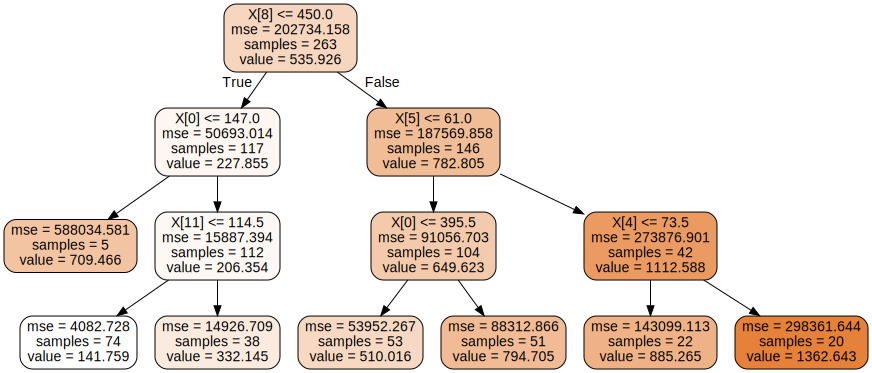

In [3]:
from sklearn.tree import export_graphviz
import graphviz

hit_tree_viz = export_graphviz(
    hit_tree,
    out_file=None,
    # feature_names=iris.feature_names[2:],
    # class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz)
graph.render('hit_tree_viz')
graph

Now let's take the validation set approach to cross validation, break the data into training set and test set, and test the MSE of our predictor.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4,
                                                    random_state=25)
hit_tree2 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=4)
hit_tree2.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

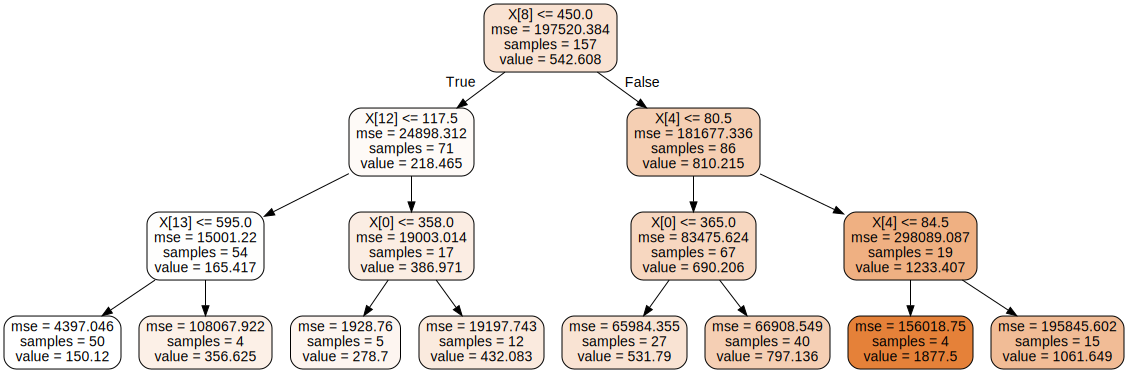

In [5]:
hit_tree_viz2 = export_graphviz(
    hit_tree2,
    out_file=None,
    # feature_names=iris.feature_names[2:],
    # class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz2)
graph.render('hit_tree_viz2')
graph

In [6]:
y_pred = hit_tree2.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 146493.11004907076


### 1.3 Classification trees
A classification tree is a decision tree that has a categorical variable as the outcome variables. For a classification tree, we predict that each observation belongs to the most commonly occurring class of training observations in the region to which it belongs. The classification error rate is simply the fraction of training observations in that region that do not belong to the most common class.

$$ ErrorRate = 1 - \max_{k}\left(\hat{p}_{m,k}\right) $$

However, classification error rate is not sensitive enough for growing trees. That is, it does not change for small changes in cutoff. For this reason, classification tree building uses either the *Gini index* or the *Entropy index* instead of the error rate.

$$ Gini = \sum_{k=1}^K \hat{p}_{m,k}\left(1 - \hat{p}_{mk}\right) $$

$$ Entropy = -\sum_{k=1}^K \hat{p}_{m,k}\ln\left(\hat{p}_{mk}\right) $$

Both the Gini index and the entropy are measures of node purity. They have values close to 0 if most of the samples in the node are in a single class (low variance) and they will both take on higher values closer to 1 if the samples in the node are in many different classes (high variance).

In [7]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

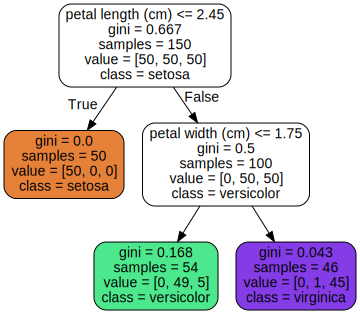

In [8]:
from sklearn.tree import export_graphviz
import graphviz

iris_tree = export_graphviz(
    tree_clf,
    out_file=None,
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(iris_tree)
graph.render('iris')
graph

### 1.4. Tuning Hyperparameters (model selection)
In Section 1.1, we fit a number of decision tree regression models to predict $log(salary)$ using the 16 features in the data. We saw that there were some key parameters of the prediction model that influenced the model's accuracy on a test data set. In particular for the `scikit-learn.tree.DecisionTreeRegressor` model, the parameters `max_depth`, `min_samples_split`, and `min_samples_leaf` are hyperparameters that influence model prediction accuracy.

Scikit Learn has built-in methods to evaluate machine learning models and optimize them across the many different combinations of hyperparameter values. The scikit-learn documentation Section 3.2 "[Tuning the hyperparameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)" is a great reference for the different methods used for hyperparameter optimization. The particular method we will focus on in this notebook is [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This method takes random permutations of the hyperparameters and chooses the permutation that has the best fit. Another good method is [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), which performs and exhaustive grid search of all possible permutations of specified hyperparameter values. This can be more computationally intensive than `RandomSearchCV`.

Let's optimize our hyperparameter values in the hitters problem above using `RandomSearchCV`.

In [23]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# specify parameters and distributions to sample from
param_dist1 = {'max_depth': sp_randint(2, 16),
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20)}

param_grid1 = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
               'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
               'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

hittree3 = DecisionTreeRegressor()

# Run randomized hyperparameter search
random_search1 = \
    RandomizedSearchCV(hittree3, param_distributions=param_dist1,
                       n_iter=500, n_jobs=-1, cv=5, random_state=25,
                       scoring='neg_mean_squared_error')

# Run grid search hyperparameter search
grid_search1 = \
    GridSearchCV(hittree3, param_grid=param_grid1,
                       n_jobs=-1, cv=5,
                       scoring='neg_mean_squared_error')

random_search1.fit(X, y)
print('RandBestEstimator1=', random_search1.best_estimator_)
print('RandBestParams1=', random_search1.best_params_)
print('RandBestScore1=', -random_search1.best_score_)

grid_search1.fit(X, y)
print('GridBestEstimator1=', grid_search1.best_estimator_)
print('GridBestParams1=', grid_search1.best_params_)
print('GridBestScore1=', -grid_search1.best_score_)

RandBestEstimator1= DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
RandBestParams1= {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 6}
RandBestScore1= 103340.90275091377
GridBestEstimator1= DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=7, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
GridBestParams1= {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 7}
GridBestScore1= 103088.64708171225


## 2. Bagging (Bootstrapping)
Decision trees constructed by recursive binary splitting are sensitive to the training set on which they are estimated. That is, if you build one tree on a random sample from a dataset, and you build another tree from a different random sample from the same dataset, both trees will likely look significantly different from each other. Bootstrapping or bagging is a general-purpose procedure for reducing the variance of any statistical learning method. It works very well with decision trees.

Bagging (or bootstrapping) is to take a large number $B$ of randomly drawn training sets from a dataset. Estimate a decision tree on each of those training sets $\hat{f}^{*b}(x)$. Then let the bagging decision tree prediction $\hat{f}_{bag}(x)$ be the average predicted value of $x$ across all the bootstrap sample trees.

$$ \hat{f}_{bag}(x) = \frac{1}{B}\sum_{b=1}^B \hat{f}^{*b}(x) $$

Bagging both reduces variance of the tree and increases predictive accuracy.

The bagging tree equation above must be adjusted if the dependent variable that we are trying to predict is categorical. A common way to aggregate predictions across bootstrapped training samples is to use a majority vote rule. The predicted value is the one that has the highest share of predicted values across the space.

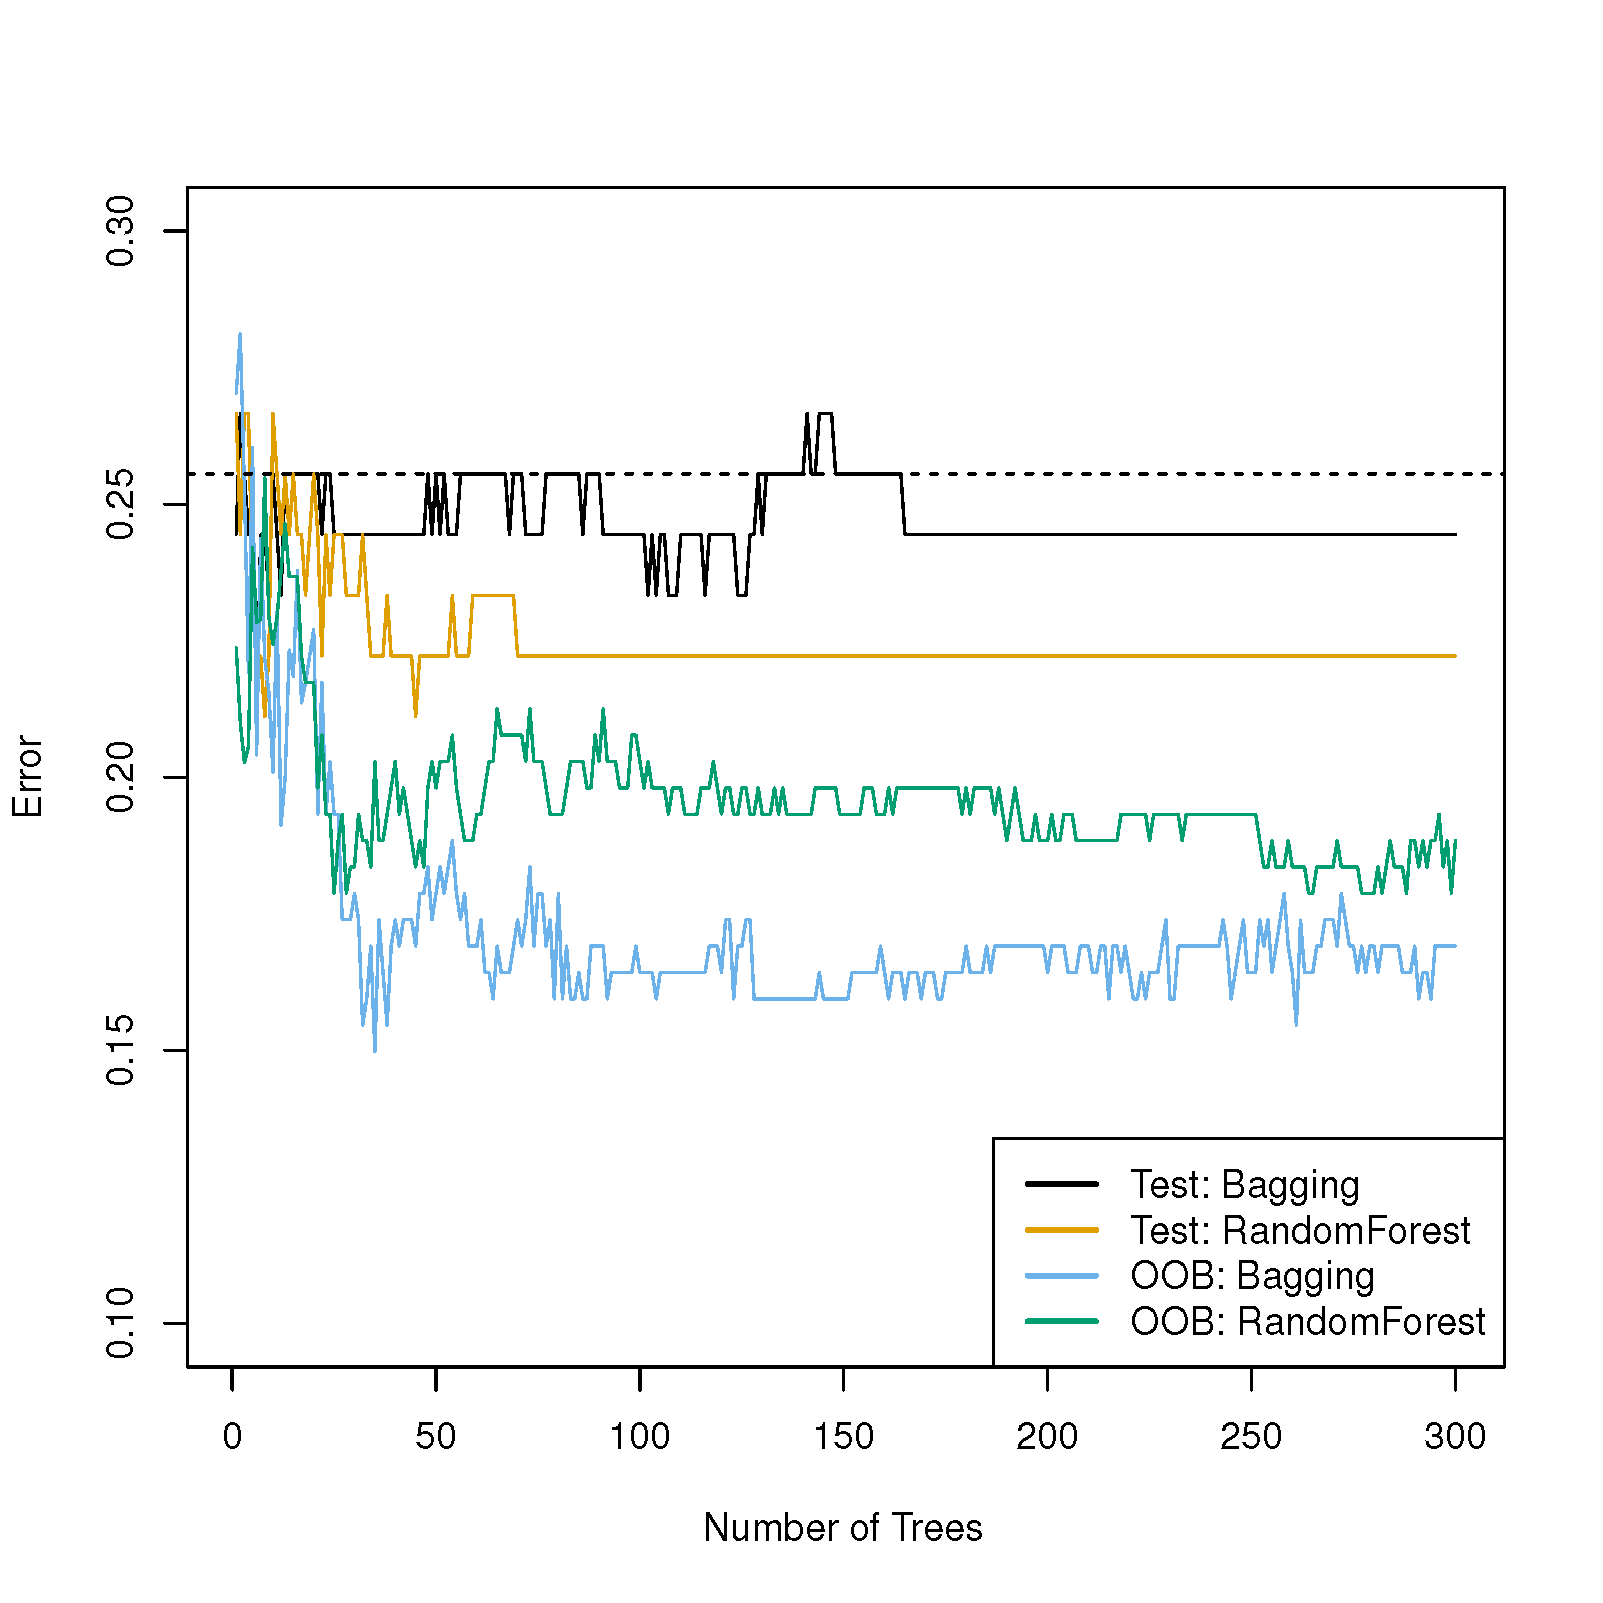

Figure 8.8 from James, et al (2013) shows the results on the error rate from using a bagging approach on some `Heart` data. The number of bootstrapped samples $B$ is shown on the $x$-axis. The number of random samples need only be as big as necessary to get the error rate to settle down, which in this case is around $B=130$.

In `scikit-learn`, there is a [`BaggingRegressor()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) function for regression trees and a [`BaggingClassifier()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) function for classification trees. These methods are called "ensemble" methods because they average an "ensemble" or collection of trees. Ensemble methods are a theme in predictive models and machine learning.

Let's do a bagging version of our `max_depth=3` regression tree with the baseball salary data. Let's see if we can get the error rate down from $MSE=121264$.

In [9]:
from sklearn.ensemble import BaggingRegressor

y = hitters['Salary'].values
X = hitters[['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks',
             'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns',
             'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']].values
print(hitters.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 17 columns):
AtBat      263 non-null float64
Hits       263 non-null float64
HmRun      263 non-null float64
Runs       263 non-null float64
RBI        263 non-null float64
Walks      263 non-null float64
Years      263 non-null float64
CAtBat     263 non-null float64
CHits      263 non-null float64
CHmRun     263 non-null float64
CRuns      263 non-null float64
CRBI       263 non-null float64
CWalks     263 non-null float64
PutOuts    263 non-null float64
Assists    263 non-null float64
Errors     263 non-null float64
Salary     263 non-null float64
dtypes: float64(17)
memory usage: 37.0 KB
None


/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
# n_estimators is how many samples from the data to take (the number of trees)
# max_samples is the maximum number of observations to include in each bootstrapped data sample
hit_tree3 = BaggingRegressor(DecisionTreeRegressor(), n_estimators=53,
                             max_samples=100, bootstrap=True, oob_score=True, random_state=25)
hit_tree3.fit(X, y)

y_pred3 = hit_tree3.oob_prediction_
MSE3 = mean_squared_error(y, y_pred3)
print('MSE=', MSE3)

MSE= 81795.88573736997


Let's plot the MSE of the bagging ensemble method as a function of the number of trees in order to estimate the optimal number of samples that gives the highest predictive accuracy.

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not hav

Min. MSE= 78683.17842347568 , Min. B= 53


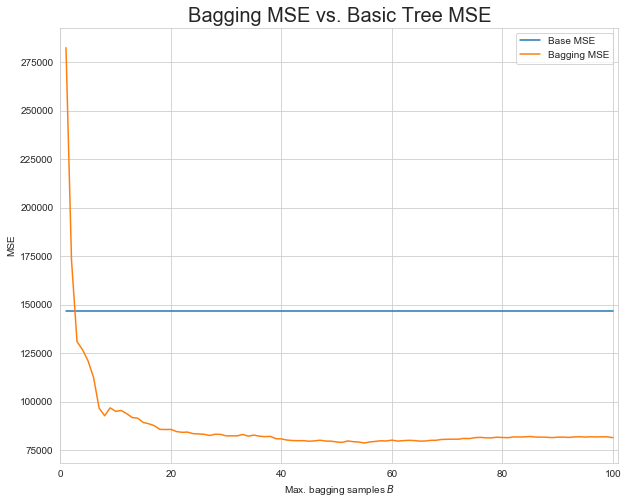

In [11]:
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

MSE_base = MSE1
max_samples = 100
MSE_vec = np.zeros(max_samples)
for ind in range(1, max_samples + 1):
    hit_tree_loop = BaggingRegressor(DecisionTreeRegressor(), n_estimators=ind,
                                 max_samples=100, bootstrap=True, oob_score=True,
                                 random_state=15)
    hit_tree_loop.fit(X, y)
    y_pred_loop = hit_tree_loop.oob_prediction_
    MSE_vec[ind - 1] = mean_squared_error(y, y_pred_loop)
    # print('MSE=', MSE_vec[ind - 1])

fig, ax = plt.subplots()
plt.plot(np.arange(1, max_samples + 1), MSE_base * np.ones(max_samples),
         label='Base MSE')
plt.plot(np.arange(1, max_samples + 1), MSE_vec, label='Bagging MSE')
# for the minor ticks, use no labels; default NullFormatter
plt.title('Bagging MSE vs. Basic Tree MSE', fontsize=20)
plt.xlabel(r'Max. bagging samples $B$')
plt.ylabel(r'MSE')
plt.xlim((0, max_samples + 1))
plt.legend(loc='best')

print('Min. MSE=', MSE_vec.min(), ', Min. B=', np.argwhere(MSE_vec == MSE_vec.min())[0, 0] - 1)

In [13]:
MSE_hat = MSE_vec[52:].mean()
MSE_std = MSE_vec[52:].std()
print('mean MSE=', MSE_hat, ', standard error=', MSE_std)

mean MSE= 80906.98626992443 , standard error= 952.790216699083


You probably noticed that we used some options that included the acronym OOB. With bagging (bootstrapped training samples), "one can show that, on average, each bagged tree makes use of around two-thirds of the observations. The remaining one-third are referred to as *out of bag* (OOB) observations." OOB error rate estimation is to use all the trees in the ensemble to predict the out of bag observations. This results in approximately $B/3$ predictions for each observation. The predicted value is then the average of all the predictions.

It can be shown that with $B$ sufficiently large, OOB error rate approaches the leave-one-out cross-validation (LOOCV) error rate. OOB is faster and more efficient than the method of averaging error rates for each random sample.

## 3. Random Forests
Bagging solves the problem of sensitivity of the estimated trees to the sample drawn for the training set by taking many samples and averaging the predictions. However, bagging does not solve the issue that the trees' structure in each sample will be correlated due to the trees using the same group of features in each sample. Random forest decision trees add one more layer of randomization that reduces the correlation in the trees that comes from a constant feature set.

A random forest continues the bagging (bootstrapping) approach, but causes each tree from a sample of observations to have a randomly determined subset of features. In other words, each tree can only use a small subset of features. The intuition is the following. Randomizing the features allows us to better explore the full set of possible predictors. A typical number of features $m$ to limit each tree to use is $m=\sqrt{P}$. This may require more bootstrapped (bagging) draws, but random forests have been shown to have better predictive accuracy than bagging alone.

`Scikit-learn` also has functions to execute random forests. [`RandomForestRegressor()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) estimates a random forest decision tree regression model, and [`RandomForestClassifier()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) estimates a random forest decision tree classifier model.

In [14]:
from sklearn.ensemble import RandomForestRegressor

B4 =53
m4 = 16
hit_tree4 = RandomForestRegressor(n_estimators=B4, max_features=m4, bootstrap=True,
                                  oob_score=True, random_state=15)
hit_tree4.fit(X, y)

hit_tree4.score(X, y)
y_pred4 = hit_tree4.oob_prediction_
MSE4 = mean_squared_error(y, y_pred4)
print('MSE=', MSE4)

MSE= 83556.65308507795


Let's compare the baseline MSE, versus the bagging MSE, versus the random forest MSE as a function of the number of random draw training sets.

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anacond

Min. bag MSE= 78683.17842347568 , Min. bag B= 53
Min. rnd MSE= 75037.00760916114 , Min. rnd B= 48


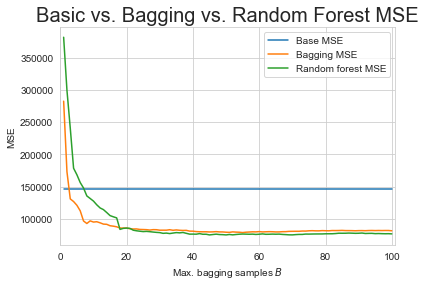

In [15]:
max_samples = 100
MSE_vec4 = np.zeros(max_samples)
for ind in range(1, max_samples + 1):
    hit_tree4_loop = RandomForestRegressor(n_estimators=ind, max_features='sqrt',
                                           bootstrap=True, oob_score=True,
                                           random_state=15)
    hit_tree4_loop.fit(X, y)
    y_pred4_loop = hit_tree4_loop.oob_prediction_
    MSE_vec4[ind - 1] = mean_squared_error(y, y_pred4_loop)
    # print('MSE=', MSE_vec[ind - 1])

fig, ax = plt.subplots()
plt.plot(np.arange(1, max_samples + 1), MSE_base * np.ones(max_samples),
         label='Base MSE')
plt.plot(np.arange(1, max_samples + 1), MSE_vec, label='Bagging MSE')
plt.plot(np.arange(1, max_samples + 1), MSE_vec4, label='Random forest MSE')
# for the minor ticks, use no labels; default NullFormatter
plt.title('Basic vs. Bagging vs. Random Forest MSE', fontsize=20)
plt.xlabel(r'Max. bagging samples $B$')
plt.ylabel(r'MSE')
plt.xlim((0, max_samples + 1))
plt.legend(loc='best')

print('Min. bag MSE=', MSE_vec.min(), ', Min. bag B=', np.argwhere(MSE_vec == MSE_vec.min())[0, 0] - 1)
print('Min. rnd MSE=', MSE_vec4.min(), ', Min. rnd B=', np.argwhere(MSE_vec4 == MSE_vec4.min())[0, 0] - 1)

## 4. Boosting
"Unlike fitting a single large decision tree to the data, which amounts to fitting the data hard and potentially overfitting, the boosting approach instead learns slowly. Given the current model, we fit a decision tree to the residuals from the model. That is, we fit a tree using the current residuals, rather than the outcome $Y$, as the response."

"By fitting small trees to the residuals, we slowly improve $\hat{f}$ in areas where it does not perform well."

The figure below is Figure 8.11 from James, et al (2013). This shows MSE performance of two boosting models versus a random forest on predicting cancer cells versus normal cells.

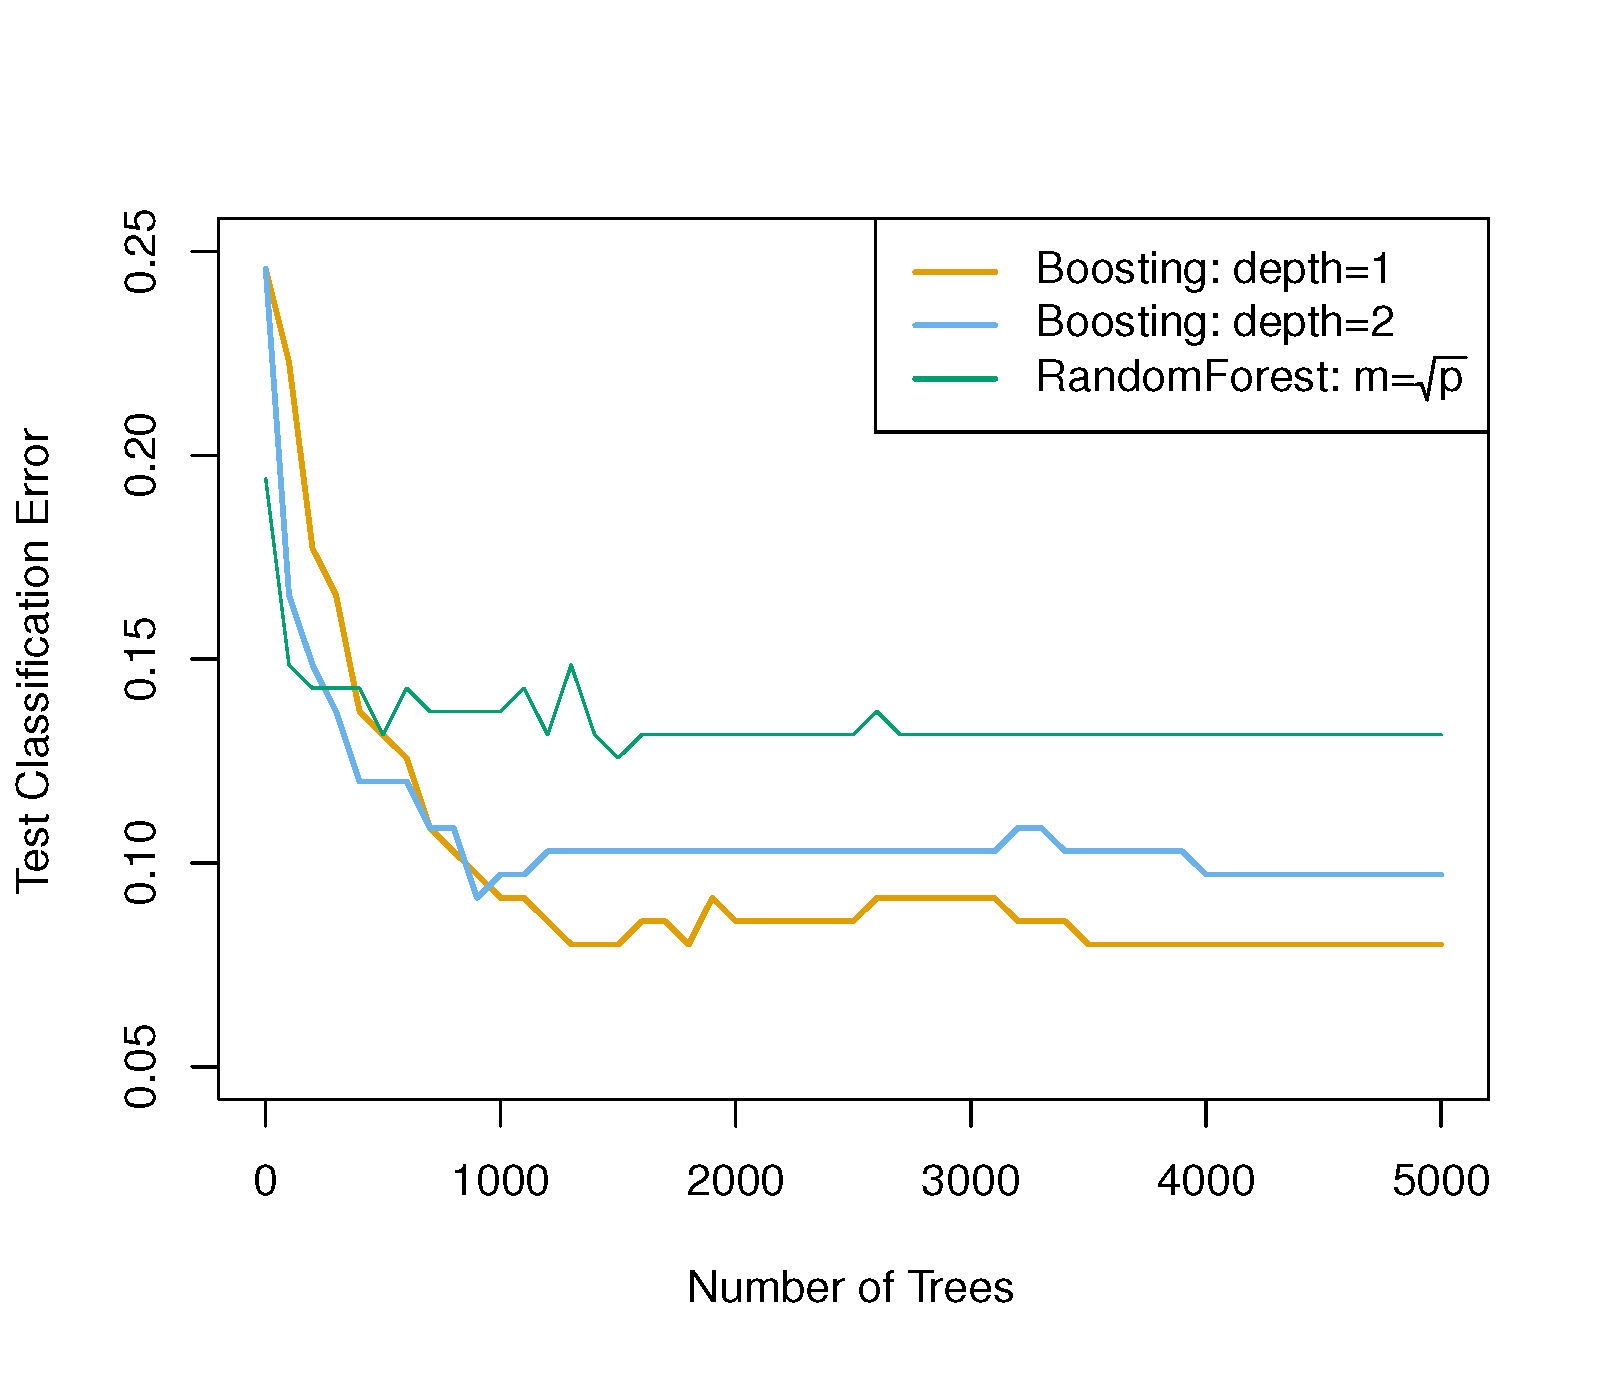

## References
* James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani, [*An Introduction to Statistical Learning with Applications in R*](http://link.springer.com.proxy.uchicago.edu/book/10.1007%2F978-1-4614-7138-7), New York, Springer (2013).